pandas (http://pandas.pydata.org/) is an open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

It's common to see pandas, numpy and matplotlib imported in the following way. We also have to specify that we would like generated images to be presented on this page. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

There are configuration options for Jupyter to do this automatically, this is useful if your notebooks will be used for similar types of data analysis.

First let's revisit the data we gathered earlier. We created a list of lists which pair up an IP address and how many times that IP address was seen in an nginx access log file.

In [2]:
ip_count = !cat access.log | awk '{print $1}' | sort | uniq -c | sort -rn
ip_count = [line.strip() for line in ip_count]
ip_count = [line.split() for line in ip_count][:10]
ip_count

[['206', '64.134.25.220'],
 ['138', '70.114.7.38'],
 ['115', '70.125.133.107'],
 ['109', '61.219.149.7'],
 ['93', '70.114.8.49'],
 ['80', '24.153.162.178'],
 ['50', '72.32.146.52'],
 ['47', '72.3.128.84'],
 ['46', '50.56.228.100'],
 ['46', '38.103.208.94']]

Now we want to take this data and have pandas be able to do something with it. We begin by creating a "DataFrame" from the 'ip_count' variable. DataFrames (DF from here on) are essentially spreadsheets that pandas can do some work on.

A common idiom in pandas is to use the 'head' and 'tail' functions to get a quick peek at the DF without having to load the entire thing (especially useful if your DF is large).

In [3]:
df = pd.DataFrame(ip_count, columns=['count', 'IP'])
df.head()

,count,IP
0,206,64.134.25.220
1,138,70.114.7.38
2,115,70.125.133.107
3,109,61.219.149.7
4,93,70.114.8.49


In [4]:
df.tail()

,count,IP
5,80,24.153.162.178
6,50,72.32.146.52
7,47,72.3.128.84
8,46,50.56.228.100
9,46,38.103.208.94


Side note: these dataframes are styled using html. Brandon Rhodes had an interesting presentation at PyCon 2015 which shows how to modify IPython's core css to style the DF: https://github.com/brandon-rhodes/pycon-pandas-tutorial I don't understand it enough to explain it so I won't be using it for this presentation

We can have pandas well us some information about the DF like what type of objects it's comprised of.

In [5]:
df.dtypes

count    object
IP       object
dtype: object

Uh-oh. We won't be able to do useful work unless pandas recognizes the 'count' column as a numeric type. 

#dtypes
Let's take a brief interlude to talk about pandas dtypes: (from http://pandas.pydata.org/pandas-docs/stable/basics.html#dtypes )

In [6]:
from pandas import Timestamp, Series
dft = pd.DataFrame(dict( A = np.random.rand(3),
                         B = 1,
                         C = 'foo',
                         D = Timestamp('20010102'),
                         E = Series([1.0]*3).astype('float32'),
                         F = False,
                         G = Series([1]*3,dtype='int8')))
dft.head()

,A,B,C,D,E,F,G
0,0.277594,1,foo,2001-01-02,1,False,1
1,0.198914,1,foo,2001-01-02,1,False,1
2,0.357611,1,foo,2001-01-02,1,False,1


Columns with string data are represented as the 'object' dtype. We'll need to coerce the data in our DF to integers to work with them further.

In [7]:
dft.dtypes

A           float64
B             int64
C            object
D    datetime64[ns]
E           float32
F              bool
G              int8
dtype: object

To get column 'count' to integers we can 'apply' a function to a column:

In [8]:
df['count'] = df['count'].apply(int)
df.dtypes

count     int64
IP       object
dtype: object

#Selecting
Now we can do some fun stuff like selecting with booleans:

In [9]:
df[df['count'] > 100]

,count,IP
0,206,64.134.25.220
1,138,70.114.7.38
2,115,70.125.133.107
3,109,61.219.149.7


If we want to chain boolean checks we need to wrap them in parens since the '&' operator takes precedence over the '>' and '<' operators. If we were to try this without the parens pandas would complain that the "truth" of a series cannot be evaluated.

In [10]:
df[(df['count'] > 100) & (df['count'] < 200)]

,count,IP
1,138,70.114.7.38
2,115,70.125.133.107
3,109,61.219.149.7


#Plotting

For now we can make a simple plot from our DF:

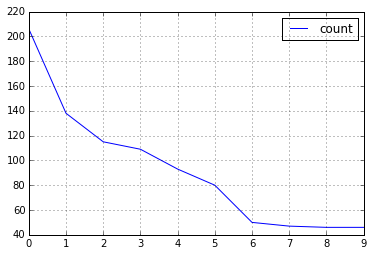

In [11]:
df.plot()

Yeah, not what we wanted at all. pandas will default to using a line graph and use it's internal index (the row numbers) to plot the data. pandas visualizations are not as full-featured as matplotlib but we can get pretty far with a few simple options:

Let's select the proper type of visualization for this data, in this case we'll use a horizontal bar chart ('barh'). We have to specify which data we expect to have plotted against the count data.

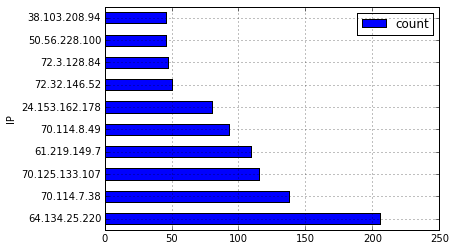

In [12]:
df.plot(kind='barh', x=df['IP'])

Ok, closer but I'd like to have the IP with the most hits at the top. We can perform transformations on the data then plot that transformed data without having to save the intermediate results.

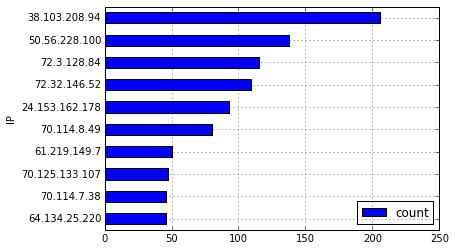

In [13]:
df.sort(columns='count', ascending=True).plot(kind='barh', x=df['IP'])

From here we can start styling the graph to reduce visual noise and making it more visually appealing. A simple way is to use the 'ggplot' style. 

ggplot (http://ggplot.yhathq.com/) is a plotting system for Python based on R's ggplot2 and the Grammar of Graphics. It is built for making profressional looking, plots quickly with minimal code. 

I haven't used it much but a discussion of it's goals can be found here: http://blog.yhathq.com/posts/ggplot-for-python.html Essentially plotting with sane defaults since:

> matplotlib is powerful...but its plotting commands remain rather verbose, and its no-frills, default output looks much more like Excel circa 1993 than ggplot circa 2013. ~ Jake Vanderplas, [Matplotlib & the Future of Visualization in Python](http://jakevdp.github.io/blog/2013/03/23/matplotlib-and-the-future-of-visualization-in-python/) ([@jakevdp](https://twitter.com/jakevdp))

Now let's see what the data would look like using ggplot:

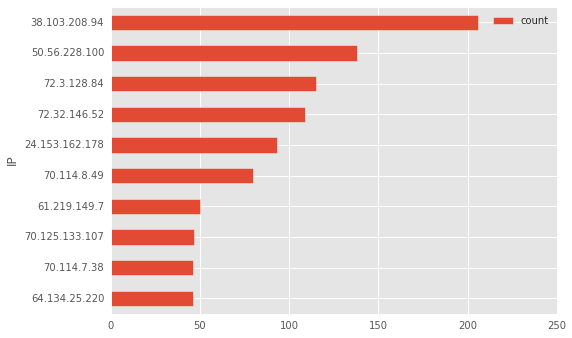

In [23]:
# use ggplot to make plots automagically better
import matplotlib
matplotlib.style.use('ggplot')

df.sort(columns='count', ascending=True).plot(kind='barh', x=df['IP'])

We can use matplotlib to configure the visualization to make it more visually appealing. In this example I'm going to try to reduce noise as much as possible while keeping the focus on the data.

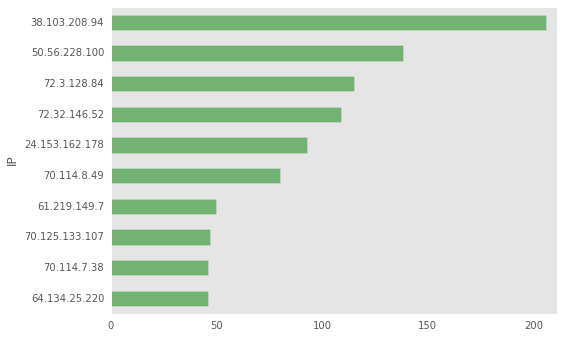

In [24]:
# primary data and plot config
df.sort(columns='count', ascending=True).plot(kind='barh', x=df['IP'], grid=False, legend=False, alpha=0.5, color='g', xlim=(0, df['count'].max() + 5))

# get plot dimensions
#xmin, xmax, ymin, ymax = plt.axis()

# plot a red line for the average of the count column
#plt.vlines(df['count'].mean(), ymin=ymin, ymax=ymax, linewidth=1.5, color='r')

# add some annotations
#plt.annotate('Average', xy=(df['count'].mean(), ymax / 3), xytext=(df['count'].mean() + 30, ymax / 2), arrowprops=dict(facecolor='black', shrink=0.05))

Let's take a look at what this data would look like using seaborn (http://stanford.edu/~mwaskom/software/seaborn/index.html#)

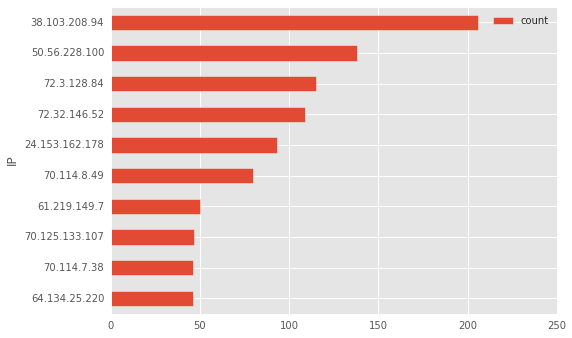

In [28]:
import seaborn as sns
df.sort(columns='count', ascending=True).plot(kind='barh', x=df['IP'])

#Public data sets

Let's try working with some public data from the TCEQ. You can download Historical Pollutant and Weather data from here: http://www.tceq.state.tx.us/airquality/monops/historical_data.html

For this example we'll get the most recent (2006) Ozone and Carbon Monoxide data which are in two seperate files which come as Excel spreadsheets (around 4MB a piece after they are unzipped)

In [15]:
%%bash
wget http://www.tceq.texas.gov/assets/public/compliance/monops/air/ozonehist/oz_2006.zip 2> /dev/null
wget http://www.tceq.texas.gov/assets/public/compliance/monops/air/ozonehist/co_2006.zip 2> /dev/null
for i in $(ls | grep zip); do unzip $i; done

Archive:  co_2006.zip
  inflating: co_2006.xls             
Archive:  oz_2006.zip
  inflating: oz_2006.xls             


We can read directly from .xls and .xlsx files into a DF like this:

In [43]:
ozone = pd.io.excel.read_excel('file://localhost/home/steven/code/acpg-may2015/oz_2006.xls')
carbon_monoxide = pd.io.excel.read_excel('file://localhost/home/steven/code/acpg-may2015/co_2006.xls')

For now we'll focus on the Ozone DF and get a better understanding of the data that we're working with. We can get the shape of the data to see how many rows and columns we're working with:

In [44]:
ozone.shape

(25399, 60)

Again using head() to take a peek at the data, we can see it consists of an 'airs' number which is a recording station, a date the measurement was taken then Ozone reading every hour. The columns are truncated so we'll have to examine that another way.

In [45]:
ozone.head(3)

,airs,date,OZ1hr0,OZ1hr1,OZ1hr2,OZ1hr3,OZ1hr4,OZ1hr5,OZ1hr6,OZ1hr7,...,oz8hr17,oz8hr18,oz8hr19,oz8hr20,oz8hr21,oz8hr22,oz8hr23,oz8hrpk,oz8hrvh,oz8hrvd
0,480290032,2006-01-01,6,2,8,10,12,15,15,15,...,11.875,8.625,10.125,13.00,16.000,19.000,21.250,34.625,24,1
1,480290032,2006-01-02,12,8,28,37,30,30,23,15,...,7.625,3.625,1.625,1.25,1.250,1.375,1.375,39.875,24,1
2,480290032,2006-01-03,1,1,1,2,2,2,1,1,...,20.875,16.500,15.375,15.75,13.375,10.250,7.000,39.250,24,1


In [68]:
ozone.columns
#for col_name in ozone.columns:
#    print col_name

Index([u'airs', u'date', u'OZ1hr0', u'OZ1hr1', u'OZ1hr2', u'OZ1hr3', u'OZ1hr4', u'OZ1hr5', u'OZ1hr6', u'OZ1hr7', u'OZ1hr8', u'OZ1hr9', u'OZ1hr10', u'OZ1hr11', u'OZ1hr12', u'OZ1hr13', u'OZ1hr14', u'OZ1hr15', u'OZ1hr16', u'OZ1hr17', u'OZ1hr18', u'OZ1hr19', u'OZ1hr20', u'OZ1hr21', u'OZ1hr22', u'OZ1hr23', u'OZunit', u'OZmetxt', u'OZmeth', u'OZ1hrvh', u'OZ1hrvd', u'OZ1hrpk', u'OZ1hrav', u'oz8hr0', u'oz8hr1', u'oz8hr2', u'oz8hr3', u'oz8hr4', u'oz8hr5', u'oz8hr6', u'oz8hr7', u'oz8hr8', u'oz8hr9', u'oz8hr10', u'oz8hr11', u'oz8hr12', u'oz8hr13', u'oz8hr14', u'oz8hr15', u'oz8hr16', u'oz8hr17', u'oz8hr18', u'oz8hr19', u'oz8hr20', u'oz8hr21', u'oz8hr22', u'oz8hr23', u'oz8hrpk', u'oz8hrvh', u'oz8hrvd'], dtype='object')

We can use regex to get just the colums that match the way 1hr measurements are named.

In [106]:
ozone_1hr = ozone.filter(regex="OZ1hr")

In [107]:
ozone_1hr.shape

(25399, 28)

Except we didn't match 'airs' and we'd like to keep that data so we know where the data is coming from

In [108]:
ozone_1hr.head()

,OZ1hr0,OZ1hr1,OZ1hr2,OZ1hr3,OZ1hr4,OZ1hr5,OZ1hr6,OZ1hr7,OZ1hr8,OZ1hr9,...,OZ1hr18,OZ1hr19,OZ1hr20,OZ1hr21,OZ1hr22,OZ1hr23,OZ1hrvh,OZ1hrvd,OZ1hrpk,OZ1hrav
0,6,2,8,10,12,15,15,15,15,23,...,16,14,6,6,5,2,24,1,41,18.625000
1,12,8,28,37,30,30,23,15,6,18,...,17,5,2,1,1,1,24,1,43,23.041667
2,1,1,1,2,2,2,1,1,2,6,...,17,6,31,30,29,6,24,1,49,18.833333
3,6,7,8,9,12,5,3,1,2,7,...,25,17,15,26,28,28,24,1,42,17.541667
4,24,26,30,27,27,28,22,17,21,31,...,29,21,25,23,21,24,24,1,43,29.791667


We can instert at a particular index (0) give it a column name ('airs') and a source for the data (ozone['airs'])

In [109]:
ozone_1hr.insert(0, 'airs', ozone['airs'])

Let's get some quick stats on the data:

Column indexing is not the most intuative, we have to pass two slices, a row slice then column slice. In this case we want all rows and all but the last 4 columns:

In [122]:
ozone_1hr.ix[:, :-4].head()

,airs,OZ1hr0,OZ1hr1,OZ1hr2,OZ1hr3,OZ1hr4,OZ1hr5,OZ1hr6,OZ1hr7,OZ1hr8,...,OZ1hr14,OZ1hr15,OZ1hr16,OZ1hr17,OZ1hr18,OZ1hr19,OZ1hr20,OZ1hr21,OZ1hr22,OZ1hr23
0,480290032,6,2,8,10,12,15,15,15,15,...,39,39,41,34,16,14,6,6,5,2
1,480290032,12,8,28,37,30,30,23,15,6,...,43,43,42,33,17,5,2,1,1,1
2,480290032,1,1,1,2,2,2,1,1,2,...,49,48,41,42,17,6,31,30,29,6
3,480290032,6,7,8,9,12,5,3,1,2,...,39,42,34,28,25,17,15,26,28,28
4,480290032,24,26,30,27,27,28,22,17,21,...,42,43,40,38,29,21,25,23,21,24


In [117]:
ozone_1hr.describe()

,airs,OZ1hr0,OZ1hr1,OZ1hr2,OZ1hr3,OZ1hr4,OZ1hr5,OZ1hr6,OZ1hr7,OZ1hr8,...,OZ1hr18,OZ1hr19,OZ1hr20,OZ1hr21,OZ1hr22,OZ1hr23,OZ1hrvh,OZ1hrvd,OZ1hrpk,OZ1hrav
count,2.539900e+04,24990.000000,24985.000000,24972.000000,24986.000000,24997.000000,25006.000000,24989.000000,24951.000000,24878.000000,...,25006.000000,25023.000000,25018.000000,24512.000000,21675.000000,24147.000000,25142.000000,25399.000000,25142.000000,25142.000000
mean,4.822774e+08,21.919408,21.139804,20.253844,19.212439,17.719526,15.729065,14.806715,17.589876,23.217823,...,33.604975,29.000480,26.149372,24.377489,23.398800,22.541517,23.598520,0.979842,48.043513,28.623246
std,1.211882e+06,13.992800,13.620939,13.261454,12.913363,12.560700,12.214279,11.680671,11.806452,12.799854,...,17.860250,16.402045,15.348681,14.754059,14.682727,14.253711,1.411306,0.140544,18.102074,11.555348
min,4.802900e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.125000
25%,4.814100e+08,11.000000,11.000000,10.000000,9.000000,7.000000,5.000000,5.000000,8.000000,14.000000,...,21.000000,17.000000,15.000000,13.000000,12.000000,12.000000,24.000000,1.000000,36.000000,20.139773
50%,4.820110e+08,21.000000,20.000000,20.000000,18.000000,17.000000,14.000000,13.000000,16.000000,22.000000,...,32.000000,28.000000,25.000000,24.000000,23.000000,22.000000,24.000000,1.000000,45.000000,27.291667
75%,4.825700e+08,31.000000,30.000000,29.000000,28.000000,26.000000,24.000000,23.000000,25.000000,31.000000,...,45.000000,40.000000,36.000000,34.000000,33.000000,32.000000,24.000000,1.000000,58.000000,35.714286
max,4.847900e+08,81.000000,77.000000,70.000000,76.000000,66.000000,63.000000,62.000000,69.000000,83.000000,...,131.000000,115.000000,98.000000,89.000000,83.000000,82.000000,24.000000,1.000000,160.000000,75.458333


Ideally each 'airs' would have 365 readings through out the year but we can see that some don't have a full dataset:

In [111]:
ozone_1hr.groupby('airs').size().head(15)

airs
480290032    365
480290052    365
480290059    365
480391004    365
480391016    363
480430101    365
480610006    334
480850005    365
481130069    365
481130075    365
481130087    365
481133003     89
481210034    365
481211032    243
481390015    365
dtype: int64

In [112]:
# from http://stackoverflow.com/a/10374456
airs_count = pd.DataFrame({'count': ozone_1hr.groupby('airs').size()}).reset_index()
airs_count.head()

,airs,count
0,480290032,365
1,480290052,365
2,480290059,365
3,480391004,365
4,480391016,363


In [113]:
airs_all_year = airs_count[airs_count['count'] == 365]
airs_all_year.head()

,airs,count
0,480290032,365
1,480290052,365
2,480290059,365
3,480391004,365
5,480430101,365


Now that we have a list of 'airs' that have 365 records, we'll only select them from our original 'ozone' variable if they exist in the 'airs_all_year' variable:

In [114]:
ozone_1hr_filtered = ozone_1hr[ozone_1hr['airs'].isin(airs_all_year['airs'])]